In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import json
import seaborn as sns
import re

In [2]:
members = pd.read_csv('../data/NSS_GreatCare_Members.csv', low_memory=False)
inpatient = pd.read_csv('../data/NSS_Hospital_Inpatient_Admissions.csv', low_memory=False)
pcp_visits = pd.read_csv('../data/NSS_PrimaryCare_Office_Visits.csv', low_memory=False)

In [55]:
pcp_visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231373 entries, 0 to 231372
Data columns (total 18 columns):
 #   Column                                         Non-Null Count   Dtype         
---  ------                                         --------------   -----         
 0   Encounter ID                                   231373 non-null  object        
 1   Patient ID                                     231373 non-null  object        
 2   Service Provider ID                            230599 non-null  object        
 3   Attending Provider ID                          39644 non-null   object        
 4   Provider Group Provider ID                     227644 non-null  object        
 5   Facility Provider ID                           39756 non-null   object        
 6   Encounter Primary Payor ID                     231373 non-null  object        
 7   Encounter Primary Plan ID                      231373 non-null  object        
 8   Attending Provider NPI                      

In [ ]:
members1 = members[['Patient ID', 'Primary Plan ID']]

In [52]:
members1.head()

NameError: name 'members1' is not defined

In [ ]:
inpatient.head()

In [3]:
#running this datetime conversion before creating the new inpatient df.
inpatient['Encounter Start Date'] = pd.to_datetime(inpatient['Encounter Start Date'], format='%Y-%m-%d')
inpatient['Encounter End Date'] = pd.to_datetime(inpatient['Encounter End Date'], format='%Y-%m-%d')

In [ ]:
# Alternate, more efficient version of converting the dates
inpatient[['Encounter Start Date','Encounter End Date']] = inpatient[['Encounter Start Date','Encounter End Date']].apply(pd.to_datetime)

In [4]:
#Also need to convert this to datetime
pcp_visits['Encounter Date'] = pd.to_datetime(pcp_visits['Encounter Date'])

In [5]:
inpatient1=inpatient[['Encounter ID', 'Patient ID', 'Encounter Start Date', 'Encounter End Date']]

In [ ]:
inpatient1.info()

In [ ]:
pcp_visits.info()

In [ ]:
#to show all the rows:
#pd.set_option('display.max_columns', None)

# Question 1
### What is our 30-day all cause readmission rate across hospitals our members are admitted to?

Process:
1. if there is a second admission date, subtract the previous visit's end date .
2. Find where the time is <= 30 days

In [6]:
#first step is to sort the inpatient1 df 
inpatient1 = inpatient1.sort_values(['Patient ID',"Encounter Start Date", "Encounter End Date"], ascending = (False, True, True))

In [7]:
#THIS IS GOLD KEEP IT.  Creates columns for us to do math on and then identify rows where the patient has been admitted twice
inpatient1['Previous End Date'] = (inpatient1.groupby('Patient ID')['Encounter End Date'].shift(1))
inpatient1['Days Since Last Visit'] = inpatient1['Encounter Start Date'] - inpatient1['Previous End Date']
inpatient1 = inpatient1[inpatient1['Days Since Last Visit'].notnull()]




In [ ]:
inpatient1.info()

In [8]:
#Creates new dataframe where time since last visit is less than or equal to 30 days
inpatient30d = inpatient1[inpatient1['Days Since Last Visit'] <= '30 days']

inpatient30d.info()
#755 rows

<class 'pandas.core.frame.DataFrame'>
Int64Index: 755 entries, 6211 to 44
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype          
---  ------                 --------------  -----          
 0   Encounter ID           755 non-null    object         
 1   Patient ID             755 non-null    object         
 2   Encounter Start Date   755 non-null    datetime64[ns] 
 3   Encounter End Date     755 non-null    datetime64[ns] 
 4   Previous End Date      755 non-null    datetime64[ns] 
 5   Days Since Last Visit  755 non-null    timedelta64[ns]
dtypes: datetime64[ns](3), object(2), timedelta64[ns](1)
memory usage: 41.3+ KB


In [9]:
#Getting the readmission within 30 days rate:
inpatient['Patient ID'].nunique() #4701
inpatient30d['Patient ID'].nunique() #479

479

In [10]:
#doing the calculation
rate = inpatient30d['Patient ID'].nunique() / inpatient['Patient ID'].nunique()
print(rate) #10.18932%

0.10189321420974261


In [ ]:
479/4701

Question 1 answer is 10.18932% rate of radmission to hospital within 30 days of discharge

## Question 1 another way

In [ ]:
#give the df a new name
inviz = inpatient1
#filter out null readmissions
inviz = inviz[inviz['Days Since Last Visit'].notnull()]
#make sure the readmissions are within 30 days
inviz = inviz[inviz['Days Since Last Visit'] <= '30 days']
inviz = inviz[inviz['Days Since Last Visit'] >= '0 days']

#and then how many people was it
total_readmission = len(inviz)
total_readmission
#this is a different count of readmissions compared to above.  Might be the >= to 0

In [ ]:
len(inpatient)

In [ ]:
#using python to get the readmission rate/percentage
total_inpatients = len(inpatient)
readmission_rate = round(total_readmission/total_inpatients * 100, 2)
readmission_rate

In [ ]:
703/6213

This route gives 11.31%. 
Different from first time answering this question..

# Question2:
### What percent of patients have a PCP visit within a week of discharge?

In [11]:
#drop duplicates! on two columns
#two_top = two_top.sort_values(['Patient ID'], ascending = (False)).drop_duplicates(['Patient ID','Encounter End Date'])

#From Brenda:
#make df and merge
ad_cut = inpatient[['Patient ID','Encounter End Date']]
pcp_cut = pcp_visits[['Patient ID','Encounter Date']]
together = ad_cut.merge(pcp_cut, left_on ='Patient ID', right_on = 'Patient ID',how='left', indicator = False)
#sort
together = together.sort_values(['Patient ID',"Encounter Date", "Encounter End Date"], ascending = (False, True, True))
#change to datetime
together['Encounter Date'] = pd.to_datetime(together['Encounter Date'], format='%Y-%m-%d')
#sub encounter date from end dates
together['Days Since Last Visit'] = together['Encounter Date'] - together['Encounter End Date']
two_top = together[together['Days Since Last Visit'] <= '7 days']
two_top = two_top[two_top['Days Since Last Visit'] >= '0 days']
two_top.rename(columns={"Encounter End Date": "Inpatient End Date"}, inplace = True)
two_top

,Patient ID,Inpatient End Date,Encounter Date,Days Since Last Visit
44074,DS1|9981,2014-08-10,2014-08-11,1 days
44077,DS1|9981,2014-08-10,2014-08-12,2 days
44071,DS1|9979,2015-02-11,2015-02-15,4 days
44067,DS1|9978,2015-09-05,2015-09-11,6 days
44051,DS1|9945,2013-02-11,2013-02-14,3 days
...,...,...,...,...
238,DS1|10303,2012-06-24,2012-06-28,4 days
231,DS1|10303,2012-06-24,2012-06-30,6 days
50,DS1|10101,2012-12-09,2012-12-12,3 days
28,DS1|10073,2012-06-21,2012-06-27,6 days


Teng below

Process:
1. Identify patients who visited PCP within 7 days of hospital discharge
2. Identify total number of inpatient visits
3. divide answer to #1 by answer to #2

In [12]:
#Getting the relevant columns
x = inpatient[['Encounter ID','Patient ID', 'Encounter Start Date', 'Encounter End Date']]
y = pcp_visits[['Encounter ID','Patient ID', 'Encounter Date']]


In [13]:
#merge! 
inpatient_pcp= x.merge(y, how = 'left', on = 'Patient ID')
inpatient_pcp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44098 entries, 0 to 44097
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Encounter ID_x        44098 non-null  object        
 1   Patient ID            44098 non-null  object        
 2   Encounter Start Date  44098 non-null  datetime64[ns]
 3   Encounter End Date    44098 non-null  datetime64[ns]
 4   Encounter ID_y        43791 non-null  object        
 5   Encounter Date        43791 non-null  datetime64[ns]
dtypes: datetime64[ns](3), object(3)
memory usage: 2.4+ MB


In [14]:
#Time between leaving hospital and visiting PCP as a new column

inpatient_pcp['7_Days'] = inpatient_pcp['Encounter Date'] - inpatient_pcp['Encounter End Date']

In [15]:
#Who visited their PCP within 7 days

# Looping through the time difference column to find any that are <= 7days and >= 0 days. 

t = []

for i in inpatient_pcp['7_Days']:
    if (i <= dt.timedelta(days=7)) and (i >= dt.timedelta(days=0)) :
        t.append('yes')
    else:
        t.append('no')

In [16]:
# Adding the list 't' as a new column 

inpatient_pcp['within_7'] = t

inpatient_pcp

,Encounter ID_x,Patient ID,Encounter Start Date,Encounter End Date,Encounter ID_y,Encounter Date,7_Days,within_7
0,HIA|DS1|10033|DS1|NPI|1306890389|1,DS1|10033,2013-01-12,2013-01-14,COV|PBSL|DS1|10033|P|1228384|1043427248|1|SHIFTED,2015-12-08,1058 days,no
1,HIA|DS1|10033|DS1|NPI|1306890389|1,DS1|10033,2013-01-12,2013-01-14,COV|PBSL|DS1|10033|P|1326684|1043427248|1|SHIFTED,2012-06-18,-210 days,no
2,HIA|DS1|10033|DS1|NPI|1306890389|1,DS1|10033,2013-01-12,2013-01-14,COV|PBSL|DS1|10033|P|155317|1043427248|1|SHIFTED,2014-06-10,512 days,no
3,HIA|DS1|10033|DS1|NPI|1306890389|1,DS1|10033,2013-01-12,2013-01-14,COV|PBSL|DS1|10033|P|439093|1043427248|1|SHIFTED,2014-09-28,622 days,no
4,HIA|DS1|10033|DS1|NPI|1306890389|1,DS1|10033,2013-01-12,2013-01-14,COV|PBSL|DS1|10033|P|711310|1043427248|1|SHIFTED,2014-03-16,426 days,no
...,...,...,...,...,...,...,...,...
44093,HIA|DS1|9994|DS1|NPI|1689608150|2,DS1|9994,2015-11-24,2015-11-27,COV|PCSL|DS1|9994|P|1238517|1407058787|2,2015-12-05,8 days,no
44094,HIA|DS1|9994|DS1|NPI|1689608150|2,DS1|9994,2015-11-24,2015-11-27,COV|PCSL|DS1|9994|P|302749|1407058787|2,2015-12-13,16 days,no
44095,HIA|DS1|9994|DS1|NPI|1689608150|2,DS1|9994,2015-11-24,2015-11-27,COV|PCSL|DS1|9994|P|781849|1205884392|1,2014-05-18,-558 days,no
44096,HIA|DS1|9994|DS1|NPI|1689608150|2,DS1|9994,2015-11-24,2015-11-27,COV|PCSL|DS1|9994|P|93182|1043427248|1,2013-07-20,-860 days,no


In [17]:
#Get the counts of within_7 column
inpatient_pcp['within_7'].value_counts()

no     41723
yes     2375
Name: within_7, dtype: int64

### Dealing with duplicates (patients who saw their PCP more than once within the 7 days after discharge)

In [18]:
#focus on the 'yes' from the 'within_7' column
yes = inpatient_pcp.loc[inpatient_pcp['within_7'] == 'yes']
type(yes)

pandas.core.frame.DataFrame

In [19]:
#remove duplicates from the yes ('Encounter ID_x' is from the inpatient visits - just count that and not multiple PCP visits)
yes = yes.drop_duplicates(subset='Encounter ID_x', keep='first')
yes #1864 rows (visits to PCP within 7 days)

,Encounter ID_x,Patient ID,Encounter Start Date,Encounter End Date,Encounter ID_y,Encounter Date,7_Days,within_7
17,HIA|DS1|10043|DS1|NPI|1902803315|1,DS1|10043,2014-01-05,2014-01-12,COV|PBSL|DS1|10043|P|538933|1043427248|1|SHIFTED,2014-01-12,0 days,yes
28,HIA|DS1|10073|DS1|NPI|1902803315|1,DS1|10073,2012-06-13,2012-06-21,COV|PBSL|DS1|10073|P|301709|1043427248|1|SHIFTED,2012-06-27,6 days,yes
50,HIA|DS1|10101|DS1|NPI|1427055839|1,DS1|10101,2012-12-06,2012-12-09,COV|PCSL|DS1|10101|P|1189971|1043427248|1,2012-12-12,3 days,yes
231,HIA|DS1|10303|DS1|NPI|1710918545|1,DS1|10303,2012-06-21,2012-06-24,COV|PBSL|DS1|10303|P|10896|1912987553|1,2012-06-30,6 days,yes
247,HIA|DS1|10305|DS1|NPI|1184722779|1,DS1|10305,2014-05-10,2014-05-12,COV|PBSL|DS1|10305|P|823298|1184722779|1,2014-05-13,1 days,yes
...,...,...,...,...,...,...,...,...
44039,HIA|DS1|9943|DS1|NPI|1184722779|3,DS1|9943,2014-10-28,2014-10-30,COV|PCSL|DS1|9943|P|1315984|1184722779|1,2014-11-03,4 days,yes
44051,HIA|DS1|9945|DS1|NPI|1902803315|1,DS1|9945,2013-02-09,2013-02-11,COV|PCSL|DS1|9945|P|840374|1043427248|1,2013-02-14,3 days,yes
44067,HIA|DS1|9978|DS1|NPI|1427055839|1,DS1|9978,2015-09-01,2015-09-05,COV|PCSL|DS1|9978|P|696226|1043427248|1,2015-09-11,6 days,yes
44071,HIA|DS1|9979|DS1|NPI|1689772592|1,DS1|9979,2015-02-06,2015-02-11,COV|PCSL|DS1|9979|P|281365|1477666352|1,2015-02-15,4 days,yes


1864 patients visited their PCP within 7 days of hospital discharge.

In [ ]:
#how many total inpatient visits were there?
x.info()

In [ ]:
#1864 patients / 6213 inpatients
1864/6213

# Question 3 
Do either vary by individual or group PCP's?

# Playing Around

In [ ]:
------- gonna try and visualize something

In [ ]:
inpatient1.head()

In [20]:
#break out new columns for year and month
inpatient1['year'] = pd.DatetimeIndex(inpatient1['Previous End Date']).year
inpatient1['month'] = pd.DatetimeIndex(inpatient1['Previous End Date']).month
inpatient1.head()

,Encounter ID,Patient ID,Encounter Start Date,Encounter End Date,Previous End Date,Days Since Last Visit,year,month
6211,HIA|DS1|9994|DS1|NPI|1689608150|2,DS1|9994,2015-11-24,2015-11-27,2015-11-23,1 days,2015,11
6202,HIA|DS1|9943|DS1|NPI|1184722779|2,DS1|9943,2013-10-25,2013-10-28,2013-10-16,9 days,2013,10
6203,HIA|DS1|9943|DS1|NPI|1184722779|3,DS1|9943,2014-10-28,2014-10-30,2013-10-28,365 days,2013,10
6199,HIA|DS1|9935|DS1|NPI|1902803315|1,DS1|9935,2011-01-25,2011-01-26,2011-01-24,1 days,2011,1
6197,HIA|DS1|9935|DS1|NPI|1366401333|1,DS1|9935,2011-01-26,2011-02-07,2011-01-26,0 days,2011,1


In [21]:
#How many under-30-days readmissions do we get, by month
by_month = inpatient1.groupby(['year','month'], as_index=False).count()
by_month = by_month.sort_values(['year','month','Patient ID'], ascending = (True, True,False))

In [ ]:
by_month.info()

In [22]:
mean = by_month['Encounter ID'].mean

TypeError: '>' not supported between instances of 'float' and 'method'

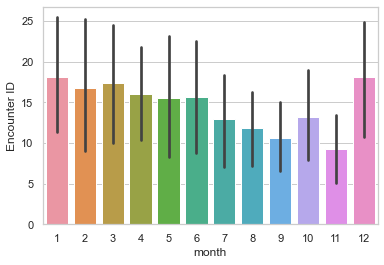

In [23]:
sns.set_theme(style="whitegrid")
ax1 = sns.barplot(x='month', y='Encounter ID',  data=by_month)
ax1.axhline(mean, color='r', linestyle='--', label="Mean")
_=ax1.legend()

# Getting a list of Frequent Flier patients

Frequent flier = someone who has been readmitted more than 3 times within a year/365 days

In [24]:
#just sorting stuff by admission date
inpatient3=inpatient1.sort_values(["Encounter Start Date"], ascending = (True))

In [25]:
#getting counts of how many visit each patient has had - all time in this data set
vc=inpatient3['Patient ID'].value_counts()
vc

DS1|3812     16
DS1|26751    14
DS1|53241    12
DS1|10451    11
DS1|24041    10
             ..
DS1|4686      1
DS1|40378     1
DS1|38743     1
DS1|27423     1
DS1|53407     1
Name: Patient ID, Length: 870, dtype: int64

In [26]:
#list of patients who have come more than 3 times
inpatient3['Patient ID'].value_counts().reset_index(name="count").query("count > 3")["index"] #75 patients

0      DS1|3812
1     DS1|26751
2     DS1|53241
3     DS1|10451
4     DS1|24041
        ...    
71     DS1|6158
72     DS1|3294
73     DS1|6139
74    DS1|31199
75    DS1|34516
Name: index, Length: 76, dtype: object

### need to figure out if repeat visits are within a year

#### Bringing in Brenda's code for easier meshing

In [134]:
#importing with Brenda's variables to repurpose "readmissions within 30 days" for 365 days
mem = pd.read_csv('../data/NSS_GreatCare_Members.csv')
adm = pd.read_csv('../data/NSS_Hospital_Inpatient_Admissions.csv')
pcp = pd.read_csv('../data/NSS_PrimaryCare_Office_Visits.csv', low_memory = False)

In [135]:
#convert to datetime
adm['Encounter Start Date'] = pd.to_datetime(adm['Encounter Start Date'], format='%Y-%m-%d')
adm['Encounter End Date'] = pd.to_datetime(adm['Encounter End Date'], format='%Y-%m-%d')
pcp['Encounter Date'] = pd.to_datetime(pcp['Encounter Date'], format='%Y-%m-%d')

In [136]:
#More brenda for reuse
#clean and transform dfs
#order by patient then start date
one = adm.sort_values(['Patient ID',"Encounter Start Date", "Encounter End Date"], ascending = (False, True, True))
#To calculate the days between admissions:
#shift previous end date to next row correct format and calculate
one['Previous End Date'] = (one.groupby('Patient ID')['Encounter End Date'].shift(1))
one['Previous End Date'] = pd.to_datetime(one['Previous End Date'], format='%Y-%m-%d')
one['Days Since Last Visit'] = one['Encounter Start Date'] - one['Previous End Date']

#ad_count is the total number of admissions
adm_count = len(one)
adm_count

6213

In [137]:

one_top = one
one_top = one_top[one_top['Days Since Last Visit'].notnull()]


In [108]:
#filter for readmission within 365 days
one_top_365 = one_top[one_top['Days Since Last Visit'] <= '365 days']
one_top_365 = one_top[one_top['Days Since Last Visit'] >= '0 days']

In [123]:
#filter for readmission within 30 days and then additional vists
one_top_30 = one_top[one_top['Days Since Last Visit'] <= '30 days']
one_top_30 = one_top[one_top['Days Since Last Visit'] >= '0 days']

In [31]:
#This is the patients who were readmitted more than 3 times - no visits more than a year apart (checked the Days Since Last Visit column)
inpatient4=one_top['Patient ID'].value_counts().reset_index(name="count").query("count > 3")["index"]
inpatient4 #73 frequent fliers from this list

0      DS1|3812
1     DS1|26751
2     DS1|53241
3     DS1|10451
4     DS1|12422
        ...    
68    DS1|35091
69    DS1|25676
70    DS1|34516
71    DS1|48279
72    DS1|59707
Name: index, Length: 73, dtype: object

In [75]:
#New dataframe for only the frequent flier patients
newdf = one_top[(one_top['Patient ID'].isin(inpatient4))]
pd.set_option('display.max_rows', None)
newdf.head()

,Encounter ID,Patient ID,Encounter Primary Payor ID,Encounter Primary Plan ID,Facility Provider ID,Attending Provider ID,Attending Provider NPI,Facility Provider NPI,Encounter Start Date,Encounter End Date,...,CMS Place of Service Code,Principal Discharge Diagnosis ICD-9-CM Code,Principal Discharge Diagnosis ICD-9-CM Description,Principal Discharge Diagnosis ICD-10-CM Code,Principal Discharge Diagnosis ICD-10-CM Description,Primary Plan Allowed Amount,Primary Plan Paid Amount,Patient Paid Amount,Previous End Date,Days Since Last Visit
5851,HIA|DS1|6506|DS1|NPI|1689772592|2,DS1|6506,DS1|1,DS1|5047W,DS1|NPI|1689772592,DS1|NPI|1811018245,1.811018e+09,1689772592,2014-12-29,2015-01-07,...,21.0,NaN,NaN,N39.0,"Urinary tract infection, site not specified",0,37316.51,0.0,2014-08-17,134 days
5852,HIA|DS1|6506|DS1|NPI|1689772592|3,DS1|6506,DS1|1,DS1|5047W,DS1|NPI|1689772592,NaN,NaN,1689772592,2015-03-18,2015-03-21,...,23.0,NaN,NaN,T82.868A,"Thrombosis due to vascular prosthetic devices,...",0,12700.00,0.0,2015-01-07,70 days
5853,HIA|DS1|6506|DS1|NPI|1689772592|4,DS1|6506,DS1|1,DS1|5047W,DS1|NPI|1689772592,DS1|NPI|1811262090,1.811262e+09,1689772592,2015-03-31,2015-04-06,...,21.0,NaN,NaN,I12.0,Hypertensive chronic kidney disease with stage...,0,36892.00,0.0,2015-03-21,10 days
5844,HIA|DS1|6506|DS1|NPI|1033298617|1,DS1|6506,DS1|1,DS1|5047W,DS1|NPI|1033298617,DS1|NPI|1952345886,1.952346e+09,1033298617,2015-07-30,2015-08-10,...,21.0,NaN,NaN,I25.10,Atherosclerotic heart disease of native corona...,0,0.00,0.0,2015-04-06,115 days
5845,HIA|DS1|6506|DS1|NPI|1033298617|2,DS1|6506,DS1|1,DS1|5047W,DS1|NPI|1033298617,DS1|NPI|1952345886,1.952346e+09,1033298617,2015-08-27,2015-08-30,...,NaN,NaN,NaN,N18.6,End stage renal disease,0,0.00,0.0,2015-08-10,17 days


In [58]:
days=newdf.sort_values(['Days Since Last Visit'], ascending = (False))
days

,Encounter ID,Patient ID,Encounter Primary Payor ID,Encounter Primary Plan ID,Facility Provider ID,Attending Provider ID,Attending Provider NPI,Facility Provider NPI,Encounter Start Date,Encounter End Date,...,CMS Place of Service Code,Principal Discharge Diagnosis ICD-9-CM Code,Principal Discharge Diagnosis ICD-9-CM Description,Principal Discharge Diagnosis ICD-10-CM Code,Principal Discharge Diagnosis ICD-10-CM Description,Primary Plan Allowed Amount,Primary Plan Paid Amount,Patient Paid Amount,Previous End Date,Days Since Last Visit
1560,HIA|DS1|23411|DS1|NPI|1902803315|6,DS1|23411,DS1|1,DS1|5047W,DS1|NPI|1902803315,DS1|NPI|1801068747,1.801069e+09,1902803315,2015-11-16,2015-11-18,...,21.0,NaN,NaN,H66.011,Acute suppurative otitis media with spontaneou...,0,11429.13,0.00,2014-12-27,324 days
174,HIA|DS1|11433|DS1|NPI|1033298617|1,DS1|11433,DS1|1,DS1|5047X,DS1|NPI|1033298617,DS1|NPI|1417911462,1.417911e+09,1033298617,2012-10-13,2012-10-26,...,NaN,NaN,NaN,E13.10,Other specified diabetes mellitus with ketoaci...,0,0.00,0.00,2011-12-25,293 days
5253,HIA|DS1|56584|DS1|NPI|1689772592|4,DS1|56584,DS1|1,DS1|5047X,DS1|NPI|1689772592,DS1|NPI|1710944889,1.710945e+09,1689772592,2012-04-22,2012-04-25,...,21.0,NaN,NaN,N39.0,"Urinary tract infection, site not specified",0,55050.24,250.00,2011-07-20,277 days
4707,HIA|DS1|5182|DS1|NPI|1902803315|2,DS1|5182,DS1|1,DS1|5047Z,DS1|NPI|1902803315,DS1|NPI|1285658500,1.285658e+09,1902803315,2015-08-11,2015-08-13,...,21.0,NaN,NaN,I73.9,"Peripheral vascular disease, unspecified",0,40161.64,250.00,2014-11-08,276 days
4815,HIA|DS1|52751|DS1|NPI|1750491247|1,DS1|52751,DS1|1,DS1|5047Z,DS1|NPI|1750491247,DS1|NPI|1346538683,1.346539e+09,1750491247,2014-05-21,2014-05-22,...,23.0,NaN,NaN,S72.011A,Unspecified intracapsular fracture of right fe...,0,8247.57,0.00,2013-08-28,266 days
326,HIA|DS1|12651|DS1|NPI|1659439834|3,DS1|12651,DS1|1,DS1|5047W,DS1|NPI|1659439834,DS1|NPI|1093833980,1.093834e+09,1659439834,2012-08-15,2012-08-16,...,NaN,NaN,NaN,T81.89XA,"Other complications of procedures, not elsewhe...",0,5087.71,250.00,2011-12-15,244 days
532,HIA|DS1|14435|DS1|NPI|1427055839|2,DS1|14435,DS1|1,DS1|5047W,DS1|NPI|1427055839,DS1|NPI|1265634604,1.265635e+09,1427055839,2015-11-24,2015-11-28,...,21.0,NaN,NaN,A41.9,"Sepsis, unspecified organism",0,22403.20,250.00,2015-04-09,229 days
80,HIA|DS1|10734|DS1|NPI|1427055839|3,DS1|10734,DS1|1,DS1|5047W,DS1|NPI|1427055839,DS1|NPI|1932307808,1.932308e+09,1427055839,2010-12-29,2011-01-04,...,21.0,NaN,NaN,I47.2,Ventricular tachycardia,0,35868.20,250.00,2010-05-21,222 days
1371,HIA|DS1|22069|DS1|NPI|1639172372|2,DS1|22069,DS1|1,DS1|5047X,DS1|NPI|1639172372,DS1|NPI|1225299563,1.225300e+09,1639172372,2012-02-27,2012-03-01,...,21.0,NaN,NaN,T86.5,Complications of stem cell transplant,0,64886.86,240.00,2011-07-26,216 days
885,HIA|DS1|17710|DS1|NPI|1427055839|2,DS1|17710,DS1|1,DS1|5047Z,DS1|NPI|1427055839,DS1|NPI|1386678746,1.386679e+09,1427055839,2013-05-10,2013-05-12,...,21.0,NaN,NaN,K56.69,Other intestinal obstruction,0,11351.10,250.00,2012-10-12,210 days


In [33]:
#Clean frequent flier dataframe for viz
ff_df = newdf[['Patient ID', 'Encounter Start Date']]
ff_df = ff_df.groupby(['Patient ID']).count()
ff_df.rename(columns = {'Encounter Start Date':'Number of Admissions'},inplace = True)

In [34]:
ff_df.reset_index(inplace=True)
#ff_df.sort_values(['Number of Admissions'], ascending=False)
ff_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73 entries, 0 to 72
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Patient ID            73 non-null     object
 1   Number of Admissions  73 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.3+ KB


Text(0, 0.5, 'Patient ID')

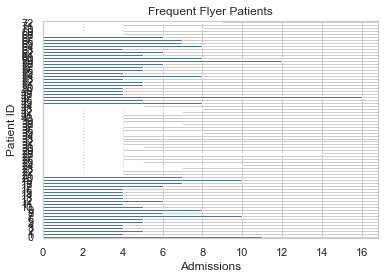

In [35]:
#Number of visits by flier
ax = ff_df.plot.barh(rot=0,legend=False)
plt.title("Frequent Flyer Patients")
plt.xlabel("Admissions")
plt.ylabel("Patient ID")

In [36]:
#Chart has too many rows, lets get the REALLY frequent fliers
ff_df1=ff_df[ff_df['Number of Admissions']>7]
ff_df1=ff_df1.sort_values(['Number of Admissions'], ascending=False)

In [37]:
ff_df1.reset_index(inplace=True)
ff_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   index                 16 non-null     int64 
 1   Patient ID            16 non-null     object
 2   Number of Admissions  16 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 512.0+ bytes


Text(0, 0.5, 'Patient ID')

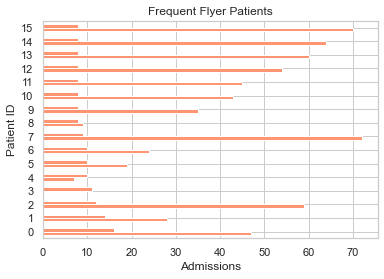

In [38]:
#Number of visits by flier (currently set to more than 7 visits)
ax = ff_df1.plot.barh(rot=0,legend=False,color='#ff9671')
plt.title("Frequent Flyer Patients")
plt.xlabel("Admissions")
plt.ylabel("Patient ID")

In [138]:
#filter for number of readmissions per patient using one_top_30 dataframe
read_count_patient = one_top.groupby(['Patient ID'], as_index=False).count()
read_count_patient = read_count_patient.sort_values(['Patient ID'], ascending = (False))
read_count_patient_high = read_count_patient[read_count_patient['Encounter ID'] >= 3]

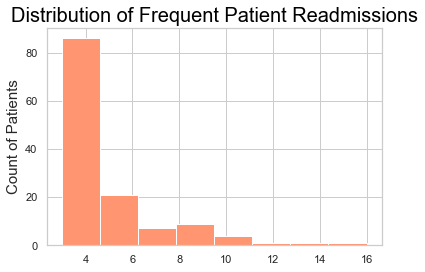

In [139]:
#Grouping the FFs by number of visits
occurance1 = read_count_patient_high
bin1 = 8
title1= 'Distribution of Frequent Patient Readmissions'
x1='Count of Readmissions'
y1='Count of Patients'
#plt.style.use('seaborn-pastel')
plt.hist('Encounter ID', bins = bin1, data = occurance1, color=['#FF9671'])
_=plt.title(title1, color = 'black', fontsize=20)
_=plt.ylabel(y1, fontsize=15)
#_=plt.xlabel(x2, fontsize=15)
#plt.savefig('../imgs/frequentfliers', transparent = True)

## Commonalities among Frequent Fliers

In [63]:
#Commonality ideas
ff_com = newdf[['Patient ID', 'Encounter Start Date', 'Facility Provider NPI', 'Principal Discharge Diagnosis ICD-10-CM Description', 'Patient Paid Amount']]
ff_com = ff_com.sort_values(['Patient ID'], ascending=False)
#ff_com = ff_com[ff_com['Number of Admissions']>7]
#ff_com.rename(columns = {'Encounter Start Date':'Number of Admissions'},inplace = True)

In [42]:
ff_com.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 430 entries, 5851 to 36
Data columns (total 5 columns):
 #   Column                                               Non-Null Count  Dtype         
---  ------                                               --------------  -----         
 0   Patient ID                                           430 non-null    object        
 1   Encounter Start Date                                 430 non-null    datetime64[ns]
 2   Facility Provider NPI                                430 non-null    object        
 3   Principal Discharge Diagnosis ICD-10-CM Description  329 non-null    object        
 4   Patient Paid Amount                                  430 non-null    float64       
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 20.2+ KB


In [60]:
ff_paid=ff_com.groupby(["Patient ID"])["Patient Paid Amount"].sum()
ff_paid.sort_values()

#type(ff_paid) #series....convert to dict and then convert to dataframe for use below
ff_paid.to_dict

In [44]:
#Turn the dict into a dataframe and add an index column
ff_paid_df=pd.DataFrame.from_dict(ff_paid)
ff_paid_df.reset_index(inplace=True)

In [ ]:
ff_paid_df.info()

Text(0, 0.5, 'Total amount paid by Patient')

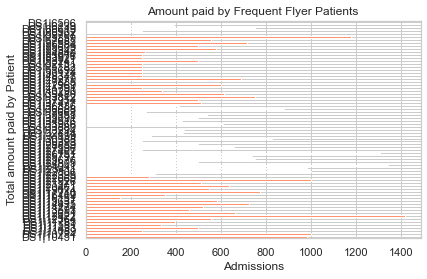

In [45]:
#Lowest paying frequent flier patients
ax = ff_paid.plot.barh(rot=0,legend=False,color='#ff9671')
plt.title("Amount paid by Frequent Flyer Patients")
plt.xlabel("Admissions")
plt.ylabel("Total amount paid by Patient")
#Too many patients for this chart to be useful - reduce

Text(0, 0.5, 'Total amount paid by Patient')

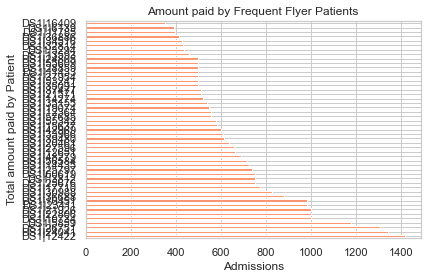

In [47]:
#Frequent fliers who have paid $350 or more
ff_lowpay = ff_paid[ff_paid>=350.00]
ff_lowpay = ff_lowpay.sort_values(ascending = (False))
#Under $500 paying frequent flier patients
ax = ff_lowpay.plot.barh(rot=0,legend=False,color='#ff9671')
plt.title("Amount paid by Frequent Flyer Patients")
plt.xlabel("Admissions")
plt.ylabel("Total amount paid by Patient")

In [ ]:
len(ff_lowpay)

Process of bringing two dataframes together

ff_df: patient id and number of admissions - 73 rows

ff_df1: patients with >7 admissions - 16 rows

ff_paid_df: patient id and sum paid - 73 rows

In [48]:
#Making a new dataframe for patient ID, # Admissions, sum paid by patient

ff_visits_sum = ff_paid_df.merge(ff_df, left_on = 'Patient ID', right_on = 'Patient ID', how='left', indicator=True)
ff_visits_sum = ff_visits_sum.sort_values(['Number of Admissions'], ascending = (True))

#this dataframe but for patients with more than 7 visits
ff_visits_sum_8 = ff_visits_sum[ff_visits_sum['Number of Admissions']>7]
ff_visits_sum_8 = ff_visits_sum.sort_values(['Number of Admissions'], ascending = (True))

In [ ]:
ff_visits_sum_8

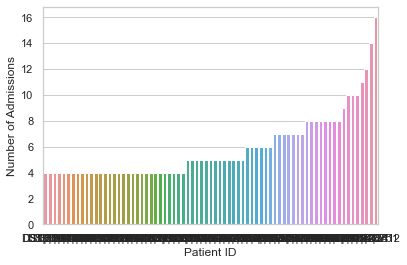

In [49]:
sns.set_theme(style="whitegrid")
ax1 = sns.barplot(x="Patient ID", y="Number of Admissions",  data=ff_visits_sum_8)
ax2 = ax.twinx()
sns.barplot(x="Patient ID", y="Patient Paid Amount", ax=ax2, data=ff_visits_sum_8)
ax.figure.legend()

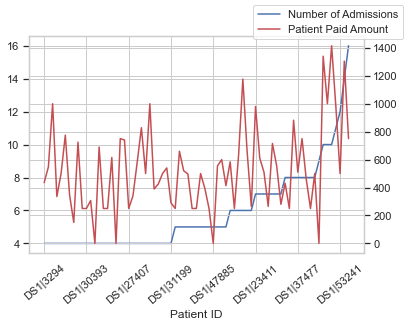

In [50]:
ax = ff_visits_sum_8.plot(x="Patient ID", y="Number of Admissions", rot=40,legend=False)
ax2 = ax.twinx()
ff_visits_sum_8.plot(x="Patient ID", y="Patient Paid Amount", ax=ax2, rot=40, legend=False, color="r")
ax.figure.legend()
plt.show()

In [ ]:
ax = ff_visits_sum_8.plot(x="Number of Admissions", y="Patient ID", rot=40, legend=False)
ax2 = ax.twinx()
ff_visits_sum_8.plot(x="Patient Paid Amount", y="Patient ID", ax=ax2, rot=40,legend=False, color="r")
ax.figure.legend()
plt.show()

In [ ]:
Do frequent fliers share PCPs?

In [ ]:
#inpatient4: list of frequent fliers.  more than 3 visits with less that 1 year between
#pcp_visits: dataframe with Patient ID and Attending Provider ID

In [64]:
#New dataframe for PCP numbers of frequent fliers
pcpdf = pcp_visits[(pcp_visits['Patient ID'].isin(inpatient4))]

In [66]:
pcpdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 895 entries, 908 to 219930
Data columns (total 18 columns):
 #   Column                                         Non-Null Count  Dtype         
---  ------                                         --------------  -----         
 0   Encounter ID                                   895 non-null    object        
 1   Patient ID                                     895 non-null    object        
 2   Service Provider ID                            895 non-null    object        
 3   Attending Provider ID                          258 non-null    object        
 4   Provider Group Provider ID                     871 non-null    object        
 5   Facility Provider ID                           259 non-null    object        
 6   Encounter Primary Payor ID                     895 non-null    object        
 7   Encounter Primary Plan ID                      895 non-null    object        
 8   Attending Provider NPI                         258 non-